In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from dataset import KeypointRandDataset, KeypointRotDataset
import albumentations as A


In [14]:
class CNNModel(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(CNNModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # Output: 16 x 5 x 5
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: 32 x 5 x 5
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 5 * 5, hidden_dim),  # Flattened input size
            nn.ReLU(),
            # nn.Linear(hidden_dim, int(hidden_dim/2)),  # Flattened input size
            # nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),  # Flattened input size
            # nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for keypoints, labels in train_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set at the end of each epoch
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model_with_metrics(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # print(f"Epoch {epoch + 1}/{epochs}")
        # print(f"Train Loss: {avg_train_loss:.4f}")
        # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_with_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            # predicted[_<0.5] = 0
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [5]:
import matplotlib.pyplot as plt

def plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs = 40):
    epochs = list(range(1, epochs+1))
    metrics = {
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies,
        "Validation Precision": val_precisions,
        "Validation Recall": val_recalls,
        "Validation F1 Score": val_f1
    }

    # Create subplots
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 18), sharex=True)

    for i, (label, values) in enumerate(metrics.items()):
        axes[i].plot(epochs, values, label=label, marker='o')
        axes[i].set_title(label)
        axes[i].set_ylabel(label)
        axes[i].grid(True)
        axes[i].legend()

    # Set common X label
    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.show()


In [15]:
import importlib
import dataset

# Reload the module
importlib.reload(dataset)

train_json = "train/_mediapipe_annotated.json"
val_json = "valid/_mediapipe_annotated.json"
test_json = "test/_mediapipe_annotated.json"
input_dim = 63  # 21 keypoints * 3 coordinates
hidden_dim = 256


In [22]:
num_classes = 26  # Adjust based on your dataset
batch_size = 16
learning_rate = 0.001
weight_decay = 0.005
epochs = 150
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
train_dataset = KeypointRotDataset(train_json,  True)
val_dataset = KeypointRotDataset(val_json, True)
test_dataset = KeypointRotDataset(test_json, True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/tianyicheng/Desktop/24Fall/11767/my_proj/dataset.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(keypoints, dtype=torch.float32), torch.tensor(category, dtype=torch.long)
/Users/tianyicheng/Desktop/24Fall/11767/my_proj/dataset.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(keypoints, dtype=torch.float32), torch.tensor(category, dtype=torch.long)
/Users/tianyicheng/Desktop/24Fall/11767/my_proj/dataset.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(keypoi

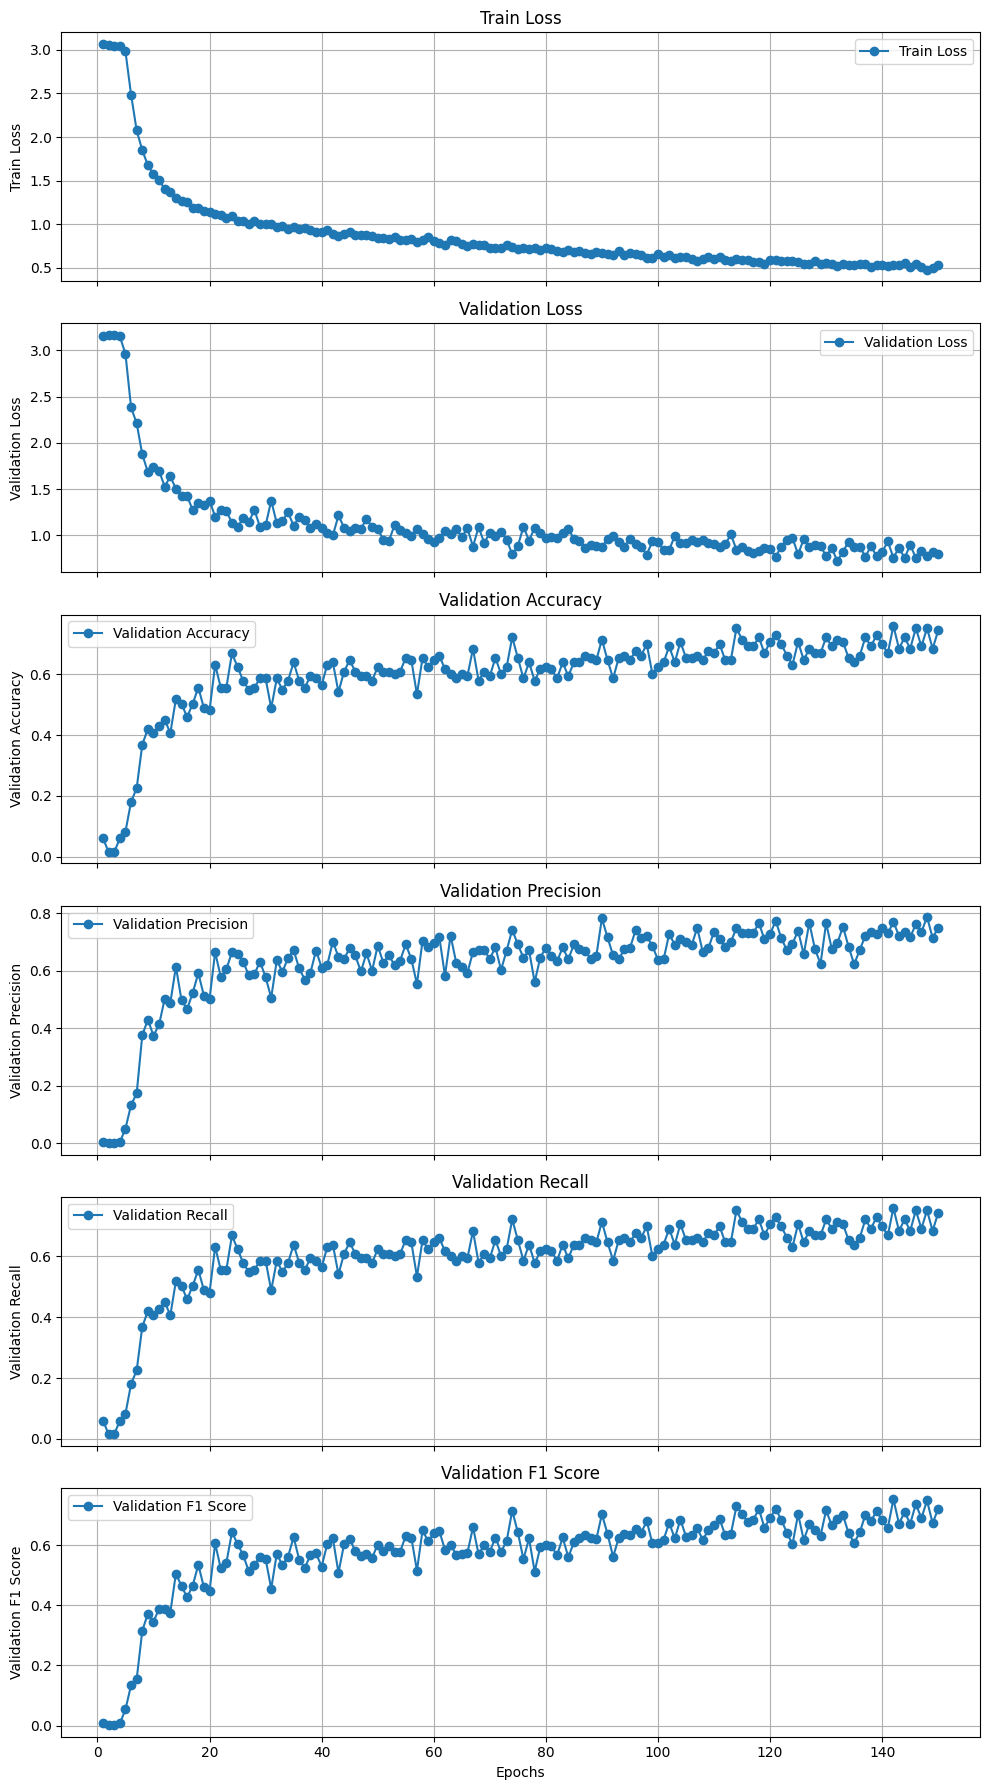

In [23]:
# Model, Loss, Optimizer
model = CNNModel(hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay = weight_decay)

# Train and Evaluate
train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1 = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs)


In [13]:
evaluate_model_with_metrics(model, val_loader,criterion, device)

/Users/tianyicheng/Desktop/24Fall/11767/my_proj/dataset.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(keypoints, dtype=torch.float32), torch.tensor(category, dtype=torch.long)


(0.9823863440089755,
 0.7518796992481203,
 0.814312567132116,
 0.7518796992481203,
 0.7591069331670836)

In [24]:
torch.save(model, "cnn_model_rot.pth")


In [24]:
torch.save(model.state_dict(), "cnn_model_new.pth")